# Cracking block ciphers with Quantum Search Grover's Algorithm
In this Notebbok we carry a simple known-plaintext attack (KPA) on a 4-bit simplifcation of ARX cipher „Speck”. We provide an approachable explanation for constructing a system of equations describing key extraction using known plaintext-ciphertext pair and cipher description. Then we propose a straight-forward preface for understaing the basics of the search algorithm and how to use it to solve the equations system, thus restoring the utilized key. Afterwards we conduct a series of computations, using both a real quantum computer and a quantum computer simulation. We analyze complexity of those computations in terms of register size, time consumption, quantity of utilized quantum gates as well as their breadths. Pinpointing those values is crucial for understaing imminent hazards looming over post-quantum security of symmetric cryptography and defining allowed thresholds of advancements, before deciding whether some of commonly used standards should be considered insecure and ameliorated to meet up the requirements. 

## Cipher description
We will start with a quick description of the cipher which we will crack. **"Speck"** is a block cipher from **ARX** family, which stands for *ADD, ROTATE, XOR* - the only operations used in this kind of encryption. The image below represents flow of the cipher.

<img src="Speck.png" alt="drawing" width="400"/>
Source: en.wikipedia.org

The algorithm is divied into two separate subroutines - **Key Schedule** (in grey) and **Encrytpion Rounds** (in yellow), both of them operate on two words, each half the size of encrypted block. First subroutine operates on words *K1, K2* and provides *Round Keys*. Those are then *XOR'ed* into encrytpted data to whiten it. The latter scrambles *Plain Text* - *PT1, PT2* and produces *Cipher Text* - *CT1, CT2*. One can easily notice that both subroutines are actually composed from identical transformations, the difference is that in **Encryption Rounds** values which are *XOR'ed* into during the process come from output of **Key Schedule** and values (nonces) *XOR'ed* into **Key Schedule** are constant, namely subsequent integers starting with (0, 1, 2, ...). Thus, for the moment we can simplify the description of the cipher and substitute those transformations with a single block - *FOO*.

<img src="SpeckFoo.png" alt="drawing" width="400"/>

Where *FOO* block accepts three input words - here we will call them *Left, Right and Side*.

## Construction of Algebraic Model
Knowing how the cipher works, our next step is to derive binary polynomials which describe values of output in terms of input values. To generate those at first we will implement basic operations used in the cipher - *ADD, ROTATE, XOR*. Those operations will accept input in form of a list of elements from Modulo 2 Field *(F2)*.

In [1]:
def rotate(reg, rot_n):
    rot_n = rot_n % len(reg)
    return tuple(reg[rot_n:] + reg[:rot_n])

def xor(l_reg, r_reg):
    assert len(l_reg) == len(r_reg)
    return tuple([ l+r for l,r in zip(l_reg, r_reg) ]) 

def add(l_reg, r_reg):
    assert len(l_reg) == len(r_reg)
    c = 0
    result = list()
    for l, r in zip(l_reg, r_reg):
        s = c + l + r
        c = (l*r) + (c*(l+r))
        result.append(s)
    return tuple(result)

**Notice**: Since data structure we are operating on is a list of *F2* elements we implement addition basing on one bit full-adders

To test those we declare elements from *F2*, we define arbitrary input from them and call the functions:

In [2]:
F = GF(2)
O, I = F(0), F(1)

left = (I, O, I, O)  #5 - left element is least significant
right = (O, O, I, I) #12

print( rotate(left, 1) )  # Expected output: (0,1,0,1)
print( xor(left, right) ) # Expected output: (1,0,0,1)
print( add(left, right) ) # Expected output: (1,0,0,0) (5 + 12 = 17 = 1 mod 16)

(0, 1, 0, 1)
(1, 0, 0, 1)
(1, 0, 0, 0)


Now, having implemented basic operations we will compose them into *FOO* block

In [3]:
def foo(left, right, side, left_rotation = 1, right_rotation = 1):
    assert len(left) == len(right)
    assert len(right) == len(side)
    
    left = rotate(left, left_rotation)
    left = add(left, right)
    left = xor(left, side)
    right = rotate(right, right_rotation)
    right = xor(left, right)
    return (left, right)

And here is an example 

In [4]:
left = (I, O, I, O)  #5
right = (O, O, I, I) #12
side = (I, O, O, O) #1

print( foo(left, right, side) )

((1, 1, 1, 0), (1, 0, 0, 0))


Further, we implement and test whole encryption algorithm

In [5]:
from itertools import product

def encrypt(K1, K2, PT1, PT2, rounds, left_rotation = 1, right_rotation = 1):
    word_size = len(K1)
    assert len(K2) == word_size
    assert len(PT1) == word_size
    assert len(PT2) == word_size

    nonces = list( product( (O, I), repeat = word_size ) )
    assert rounds < len(nonces)
    
    for i, nonce in zip( range(rounds - 1), nonces):
        PT1, PT2 = foo(PT1, PT2, K2, left_rotation, right_rotation)
        K1, K2 = foo(K1, K2, nonce, left_rotation, right_rotation)
    
    PT1, PT2 = foo(PT1, PT2, K2, left_rotation, right_rotation)
    
    return (PT1, PT2)   

In [6]:
K1 = (I, O, I, O)  #5
K2 = (O, O, I, I) #12
PT1 = (I, O, O, O) #1
PT2 = (I, O, O, I) #9
rounds = 1
encrypt(K1, K2, PT1, PT2, rounds)

((1, 0, 1, 1), (1, 0, 0, 0))

At this moment we have whole encrytpion algorithm ready to use, which works for constant input values. Our goal is to use the very same algorithm to compute polynomials describing *Cipher Text* values. 

To achieve this, we declare binary polynomial ring with 4 variables for *Key* and 4 variables for *Plain Text*

In [7]:
from sage.rings.polynomial.pbori import declare_ring, Block

R = declare_ring( [Block('k', 4), Block('p', 4)] )

K = R.gens()[0:4]
P = R.gens()[4:8]

print(K) #List of all (4) key vairables
print(P) #List of all (4) plaintext variables

(k(0), k(1), k(2), k(3))
(p(0), p(1), p(2), p(3))


Since we want to attack 4 bit version of the cipher we split those variables into respecting words, 2 bits each:

In [8]:
K1 = K[0:2]
K2 = K[2:4]
PT1 = P[0:2]
PT2 = P[2:4]

And finally use encryption algorithm to achieve *Cipher Text* polynomials

In [9]:
rounds = 2
CP1, CP2 = encrypt(K1, K2, PT1, PT2, rounds)
CP = (*CP1, *CP2)
for i, c in enumerate(CP):
    print(f"c({i}) = {c}")

c(0) = k(1) + p(0) + p(1)*p(2) + p(1) + p(2)
c(1) = k(0) + k(1)*k(2) + k(2)*k(3) + k(2)*p(0) + k(2)*p(1)*p(2) + k(2)*p(3) + k(3)*p(1) + k(3)*p(2) + k(3)*p(3) + p(0)*p(1) + p(0)*p(2) + p(0)*p(3) + p(0) + p(1)*p(2)*p(3) + p(1)*p(2) + p(1)*p(3) + p(1) + p(2)*p(3)
c(2) = k(1) + k(3) + p(1) + p(3)
c(3) = k(0) + k(1)*k(2) + k(2)*k(3) + k(2)*p(0) + k(2)*p(1)*p(2) + k(2)*p(3) + k(2) + k(3)*p(1) + k(3)*p(2) + k(3)*p(3) + p(0)*p(1) + p(0)*p(2) + p(0)*p(3) + p(0) + p(1)*p(2)*p(3) + p(1)*p(2) + p(1)*p(3) + p(2)*p(3) + p(2) + p(3)


## Defining equation system
Having full mathematical model for the cipher, we have to acquire a *Plain Text - Cipher Text* pair, which we will use to create appropriate equation system. In case of real attack, this pair has to bo somehow intercepted, but here we have the comfort of possibility to create our own. We can use either **encrypt** function *OR* *Cipher Text* polynomials.

#### Using **encrypt** function:

In [10]:
K1 = (I, O)
K2 = (I, O)
PT1 = (I, O)
PT2 = (O, I)
rounds = 2
C1, C2 = encrypt(K1, K2, PT1, PT2, rounds)
C = (*C1, *C2)
print(f"{C = }")

C = (1, 1, 1, 1)


#### Using polynomials:

In [11]:
K1 = (I, O)
K2 = (I, O)
PT1 = (I, O)
PT2 = (O, I)
C = [ cp(*K1, *K2, *PT1, *PT2) for cp in CP ]
print(f"{C = }")

C = [1, 1, 1, 1]


Now, we will use this pair to create equation system. To do this, we have to apply known *Plain Text* as input, *Key* as variables and compare it to the output - *Cipher Text*. Comparison is accomplished via addition and comparing to 0.

In [12]:
K1 = K[0:2] #Unknown
K2 = K[2:4] #Unknown
PT1 = (I, O)
PT2 = (O, I)
ES = [ cp(*K1, *K2, *PT1, *PT2) + c for cp, c in zip(CP, C) ]
for e in ES:
    print(e)

k(1)
k(0) + k(1)*k(2) + k(2)*k(3) + k(3) + 1
k(1) + k(3)
k(0) + k(1)*k(2) + k(2)*k(3) + k(2) + k(3)


Here, we can check wether the system is correct by apllying known key - in real scenario it is impossible due to lack of key.

In [13]:
K1 = (I, O)
K2 = (I, O)
Verify = [ e(*K1, *K2, O, O, O, O) for e in ES ]  #first 4 zeroes are insignifcant place-holders for plain-text variables and don't affect the outcome.
print(Verify)

[0, 0, 0, 0]


Acquiring all-zero list means that key value satisfies the equation system proving it is a correct one to use for key extraction. 

## Solving the system


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import boto3
from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

my_bucket = "amazon-braket-m4da-bucket" # the name of the bucket
my_prefix = "foo" # the name of the folder in the bucket


s3_folder = (my_bucket, my_prefix)
sv_device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
ionq_device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
device = LocalSimulator()

In [15]:
from cmath import pi, phase
from math import log

def pow_2_divisor(n):
    n = int(n)
    return int(log(n & (~(n - int(1))), 2))

def czn(circuit, controls, theta = pi):
    lc = len(controls)
    if lc > 1:
        czn(circuit, controls[:-1], theta/2)
        
        theta = theta / pow(2, lc-1)
        circuit.cnot(controls[-2], controls[-1])
    
        for i in range(1, pow(2, lc-1)):
            circuit.rz(controls[-1], theta*pow(-1,i))
            index = pow_2_divisor(i)
            circuit.cnot(controls[index], controls[-1])
            
        circuit.rz(controls[-1], theta)  
    else:
        circuit.rz(controls[0], theta)

def toffoli(circuit, controls, target):
    assert len(controls) == 2
    c0, c1 = controls
    circuit.h(target)
    circuit.cnot(c1, target)
    circuit.ti(target)
    circuit.cnot(c0, target)
    circuit.t(target)
    circuit.cnot(c1, target)
    circuit.ti(target)
    circuit.cnot(c0, target)
    circuit.t(c1)
    circuit.t(target)
    circuit.cnot(c0, c1)
    circuit.h(target)
    circuit.t(c0)
    circuit.ti(c1)
    circuit.cnot(c0, c1)
        
def mcx(circuit, controls, target):
    L = len(controls)
    if L == 0:
        circuit.x(target)
    elif L == 1:
        circuit.cnot(*controls, target)
    elif L == 2:
        toffoli(circuit, controls, target)
    else:
        circuit.h(target)
        czn(circuit, controls + [target])
        circuit.h(target)

def int_to_ket(num, length = None):
    if not length:
        length = num.bit_length()
    bits = "{:b}".format(num).zfill(length)
    return "|" + bits + ">"
    
def sv_pprint(values):
    l = int(abs(log(len(values), 2)))
    index = next((i for i, x in enumerate(values) if x), None)
    if index:
        modulus = abs(values[index])
        global_phase = values[index] / modulus
        reduced_phase =  [v / global_phase for v in values]
    else:
        reduced_phase = values
    for i,v in enumerate(reduced_phase):
        ket = int_to_ket(i, l)
        if ket[5:9] == "0000":
            print( f"{ket} : { round(v.real, 2):8.4f}, { round(v.imag, 2):8.4f},   amp = {abs(v)**2:6.4f},   phase = {phase(v):6.4f}" )

In [16]:
def es_filter(circuit, ES, v_num):
    for i, eq in enumerate(ES):
        for term in eq.terms():
            variables = [v.index() for v in term]
            mcx(circuit, variables, i + v_num)
        circuit.x(i + v_num)
        
def es_oracle(circuit, ES, v_num):
    es_filter(circuit, ES, v_num)
    czn( circuit, range(v_num, v_num + len(ES)) )
    es_filter(circuit, ES, v_num)

def grover_mirror(circuit, qubits):
    circuit.h(qubits)
    circuit.x(qubits)
    czn(circuit, qubits)
    circuit.x(qubits)
    circuit.h(qubits)

def grover(circuit, ES, v_num, rounds):
    mc.h(range(v_num))    
    for i in range(rounds):
        es_oracle(mc, ES, v_num)
        grover_mirror(mc, range(v_num))

In [17]:
mc = Circuit()
grover(mc, ES, 4, 3)

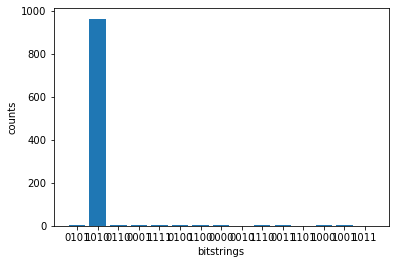

In [18]:
task = device.run(mc, shots=int(1000))
result = task.result()
counts = result.measurement_counts
plt.bar([c[0:4] for c in counts.keys()], counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

In [19]:
#task = ionq_device.run(mc, s3_folder, shots=int(1000))
#print(task.id)

In [20]:
#result = task.result()
#counts = result.measurement_counts
#plt.bar([c[:4] for c in counts.keys()], counts.values());
#plt.xlabel('bitstrings');
#plt.ylabel('counts');